Processing FloorSet-Lite Batches:   0% 0/7650 [00:00<?, ?it/s]

area targets: torch.Size([128, 100]) b2b_connectivity: torch.Size([128, 2200, 2]) p2b_connectivity: torch.Size([128, 648, 2]) pins_pos: torch.Size([128, 324, 2]) placement_constraints: torch.Size([128, 100, 5]) target floorplan solution: torch.Size([128, 100, 4]) target tree solution: torch.Size([128, 99, 3]) target metrics: torch.Size([128, 8])


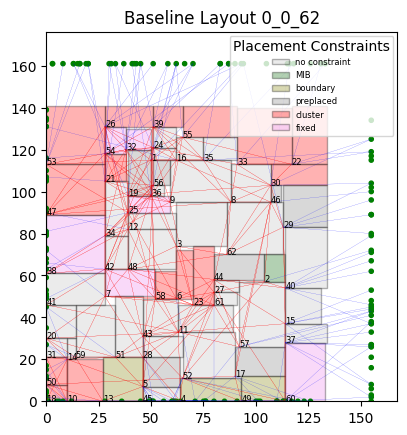

Processing FloorSet-Lite Batches:   0% 0/7650 [00:02<?, ?it/s]


In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm 
from lite_dataset import FloorplanDataset, floorplan_collate
from visualize import visualize_lite

def main():
    root = './'
    ds = FloorplanDataset(root)
    # Avoid shuffling to make file caching more effective
    dl = DataLoader(ds, batch_size=128, shuffle=False,
                    collate_fn=floorplan_collate)
    
    # A minibatch can contain floorplans with different number of blocks or pins
    # All tensors in a minibatch are padded to the maximum number of blocks and pins in the minibatch
    # The padding for the LongTensors is -1, for the bool tensors it is False
    for batch_idx, batch in tqdm(enumerate(dl), total=len(dl), desc='Processing FloorSet-Lite Batches'):
        (
            area_target,   # bsz x n_blocks. The area target values for each block
            b2b_connectivity,  # bsz x b2b_edges x weight. The block-to-block connectivity
            p2b_connectivity,  # bsz x p2b_edges x weight. The pin-block connectivity
            pins_pos,  # bsz x n_pins x 2. The pins location
            placement_constraints, # bsz x n_blocks x 5. [fixed, preplaced, multi-instantiation, cluster, boundary]
            tree_sol, # bsz x (n_blocks-1) x 3. The B*Tree representation of the floorplans (rectangular partitions + compact floorplans)
            fp_sol, # bsz x n_blocks x 4. The size(:,:,:2) and the ground truth position(:,:,2:4) of the blocks
            metrics_sol # [area, num_pins, num_total_nets, num_b2b_nets, num_p2b_nets, num_hardconstraints, b2b_weighted_wl, p2b_weighted_wl]
        ) = batch 
        print(
            f'area targets: {area_target.size()}', 
            f'b2b_connectivity: {b2b_connectivity.size()}', 
            f'p2b_connectivity: {p2b_connectivity.size()}', 
            f'pins_pos: {pins_pos.size()}', 
            f'placement_constraints: {placement_constraints.size()}', 
            f'target floorplan solution: {fp_sol.size()}', 
            f'target tree solution: {tree_sol.size()}', 
            f'target metrics: {metrics_sol.size()}', 
            )

        # Visualize results of the first samples of each batch
        target_row = torch.tensor([-1, -1, -1, -1])
        for vis_ind in range(1):
            mask = ~torch.all(fp_sol[vis_ind] == target_row, dim=1)
            num_blocks = torch.sum(mask).item()
            layout_ind = str(batch_idx)+'_'+str(vis_ind)+'_'+str(num_blocks)
            visualize_lite(
                fp_sol[vis_ind], 
                b2b_connectivity[vis_ind], 
                p2b_connectivity[vis_ind], 
                pins_pos[vis_ind], 
                placement_constraints[vis_ind],
                layout_ind
            )
        break

if __name__ == "__main__":
    main()
